In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# 그래프 기본 테마 설정
sns.set_style("white")
sns.set_context("notebook")

# 폰트 적용
import platform
from matplotlib import font_manager as fm
font_path = "font/NanumGothic.ttf"

font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()

# 그래프 기본 설정
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['axes.facecolor'] = 'white'      # 축 배경 흰색
plt.rcParams['figure.facecolor'] = 'white'    # 전체 배경 흰색
plt.rcParams['axes.grid'] = False             # 그리드 제거
plt.rcParams['savefig.facecolor'] = 'white'   # 저장 이미지 배경도 흰색

# 경고 무시
import warnings
warnings.filterwarnings('ignore')

# 복잡한 통계 처리를 위한 라이브러리
from scipy import stats

In [2]:
df = pd.read_csv('data/merged_data_brand_dropna.csv')

KeyboardInterrupt: 

In [3]:
# datetime 컬럼 변환
df['event_time_moscow'] = pd.to_datetime(df['event_time_moscow'])

In [4]:
# 최초 이벤트가 'view'인 사용자만 추출
first_event = df.sort_values('event_time_moscow').groupby('user_id').first().reset_index()
users_first_event_is_view = first_event[first_event['event_type'] == 'view']['user_id'].unique()

# 해당 사용자만 원본 데이터에서 필터링
df = df[df['user_id'].isin(users_first_event_is_view)].copy()

# 사용자별 최초 view 시점(cohort_start) 계산
view_df = df[df['event_type'] == 'view'].copy()
cohort_start = view_df.groupby('user_id')['event_time_moscow'].min().reset_index()
cohort_start.columns = ['user_id', 'cohort_start']

# cohort_start 병합
df = df.merge(cohort_start, on='user_id', how='left')

# 경과일(days_since_first_view) 계산 및 음수 제거
df['days_since_first_view'] = (df['event_time_moscow'] - df['cohort_start']).dt.days
df = df[df['days_since_first_view'] > 0]

# 전환 여부 태그 추가
purchase_users = df[df['event_type'] == 'purchase']['user_id'].unique()
df['converted'] = df['user_id'].isin(purchase_users)

In [5]:
cohort_behavior = df.groupby(['converted', 'days_since_first_view', 'event_type']).size().reset_index(name='count')

In [6]:
pivot_df = cohort_behavior.pivot_table(
    index='days_since_first_view',
    columns=['converted', 'event_type'],
    values='count',
    fill_value=0
)

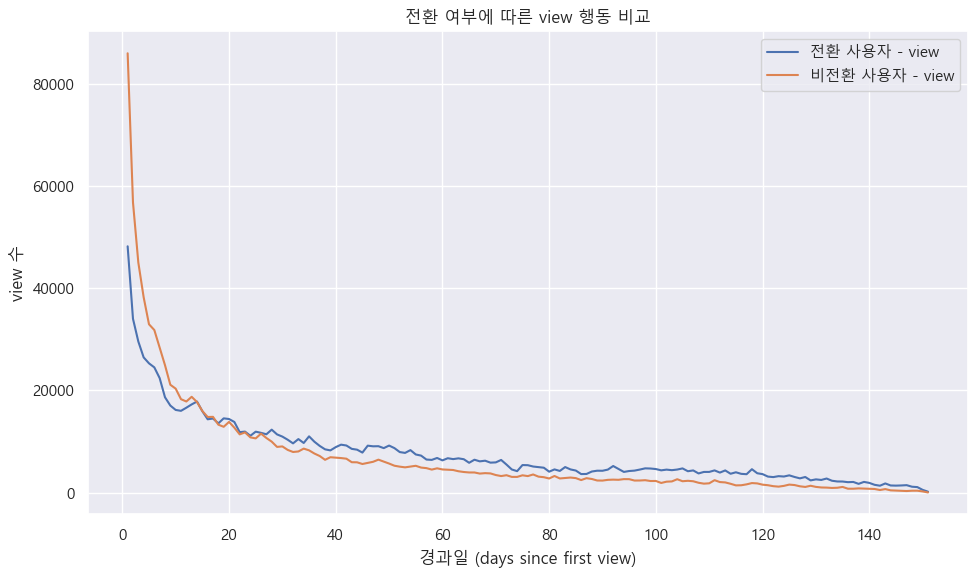

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(pivot_df.index, pivot_df[(True, 'view')], label='전환 사용자 - view')
plt.plot(pivot_df.index, pivot_df[(False, 'view')], label='비전환 사용자 - view')
plt.xlabel('경과일 (days since first view)')
plt.ylabel('view 수')
plt.title('전환 여부에 따른 view 행동 비교')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
from scipy.stats import ttest_ind

# 예시: 1~7일 view 수 합계 비교
converted_views = df[(df['converted']) & (df['event_type'] == 'view') & (df['days_since_first_view'] <= 7)]
nonconverted_views = df[(~df['converted']) & (df['event_type'] == 'view') & (df['days_since_first_view'] <= 7)]

# 사용자별 일주일 view 수 집계
converted_counts = converted_views.groupby('user_id').size()
nonconverted_counts = nonconverted_views.groupby('user_id').size()

# t-test 수행
t_stat, p_val = ttest_ind(converted_counts, nonconverted_counts, equal_var=False)
print(f"p-value: {p_val:.4f}")

p-value: 0.0000


In [19]:
# 1. view 이벤트만 필터링
view_df = df[df['event_type'] == 'view'].copy()

# 2. 전환 여부와 경과일 기준 view 수 집계
daily_view = view_df.groupby(['days_since_first_view', 'converted'])['user_id'].count().reset_index()
daily_view.columns = ['days_since_first_view', 'converted', 'view_count']

# 3. 피벗 테이블로 정리: 행 = 경과일, 열 = 전환 여부
view_table = daily_view.pivot(
    index='days_since_first_view',
    columns='converted',
    values='view_count'
).fillna(0)

# 4. 컬럼 이름 변경 (True/False → 보기 쉽게)
view_table.columns = ['비전환 사용자', '전환 사용자']  # False → 비전환, True → 전환

# 5. 선택: 두 그룹의 차이도 추가
view_table['전환 - 비전환 차이'] = view_table['전환 사용자'] - view_table['비전환 사용자']

# 6. 표 출력
import pandas as pd
from IPython.display import display

display(view_table.head(20))  # 상위 20일차만 보기 (원하시면 변경 가능)

,비전환 사용자,전환 사용자,전환 - 비전환 차이
days_since_first_view,,,
1,85992,48219,-37773
2,56828,34038,-22790
3,45061,29591,-15470
4,38260,26482,-11778
5,32962,25315,-7647
6,31835,24525,-7310
7,28394,22424,-5970
8,24958,18676,-6282
9,21124,17053,-4071
